# Overview of Methods

The methods used for feature extraction and feature aggregation were inspired by Jean et al. (2016). The pre-trained CNN used was a PyTorch implementation of the Caffe CNN used in Jean et al. (2016). In order to extract the features for each ward, we did the following:

1. Using batches of size $8$, we passed the images through the modified VGG16 CNN as follows:
    * The data was passed through the feature extracting layers. Then through an average pooling layer.
    * Using the mask for the particular image, we then resized the mask to the same size as the output of the average pooling layer and applied the mask to each of the filter maps present in the output of the average pooling layer.
    * The resulting output was then flattened and passed through the first 4 layers of the fully-connected portion of the CNN.
    * The output from these fully-connected layers were regarded as the features.
2. The features were then averaged across the ward (i.e. across each of the images for the ward).


# Libraries Used

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

import cv2

# Constants

In [166]:
MUNICIPALITY = 'Westonaria'

In [167]:
BASE_DIR = '..'
CNN_IMAGE_DIR = os.path.join(BASE_DIR, 'images', MUNICIPALITY)
CNN_DIR = os.path.join(BASE_DIR, 'models', 'trained_model.pt')
DATA_DIR = os.path.join(BASE_DIR, 'data', 'image_centers')

In [168]:
df_ward_centers = pd.read_csv(os.path.join(DATA_DIR, "{}_ward_image_centers.csv".format(MUNICIPALITY))) 
N_WARDS = df_ward_centers.shape[0]
N_WARDS

16

# Feature extract with CNN

Enabling GPU if one is available:

In [169]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} as backend')
model = torch.load(CNN_DIR, map_location=device)

Using cpu as backend


### CNN models used

Full model:

In [170]:
model  # full model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

Model which we will use:

In [171]:
# rip off the final layers
model.classifier = model.classifier[:4]
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

The images are passed through the feature extractor, then the average pooling and the layers of the classifier serve as dimension reduction.

However, since we need to isolate an ROI from the features extracted, we breakdown the layers into their specific components, namely: feature extracting layers, average pooling layer and the classifier layers. By doing this, we can insert operations between the layers before feeding the data back into the next layer.

Feature extracting layers:

In [172]:
mod_get_features = model.features[:30]
mod_get_features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

Isolating the section of the classifier which we will use:

In [173]:
mod_reduce_dim = model.classifier
mod_reduce_dim

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
)

Thus, the layers can be summaryised as follows:

In [174]:
# eval() ensures only forward pass is run 
mod_get_features.eval()
adapt_ave = nn.AdaptiveAvgPool2d((7,7))
mod_reduce_dim.eval()

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
)

Creating a dataframe to store all the aggregated features:

In [175]:
feat_names = [str(i) for i in range(4096)]
cols = ["ward_no.", "Municipality"]
cols.extend(feat_names)
features_df = pd.DataFrame(0, index=np.arange(N_WARDS), columns=cols)
features_df["ward_no."] = np.arange(1, N_WARDS+1)
features_df.set_index('ward_no.', inplace=True)
features_df['Municipality'] = MUNICIPALITY
features_df.head()

,Municipality,0,1,2,3,4,5,6,7,8,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
ward_no.,,,,,,,,,,,,,,,,,,,,,
1,Westonaria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Westonaria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Westonaria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Westonaria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Westonaria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [176]:
transformer = transforms.Compose([
            transforms.ToTensor(),                                                 # converting img to tensor
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])     # normalizing tensor pixels
        ])

# custom dataset for fast image loading and processing
class ForwardPassDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transformer):
        self.image_dir = image_dir
        self.image_list = os.listdir(self.image_dir)
        self.transformer = transformer

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image_name = self.image_list[index]

        # Load image
        X = self.filename_to_im_tensor(self.image_dir + '/' + image_name)
        
        # dataloaders need to return a label, but for the forward pass we don't really care
        return X, -1
    
    def filename_to_im_tensor(self, file):
        im = plt.imread(file)[:,:,:3]
        im = self.transformer(im)
        return im

In [177]:
# setting features outside of the ward to zero
def isolate(img, inds):
    img[inds] = 0
    return img

In [178]:
# using the mask to select which pixels fall within the ward boundaries
def apply_mask(filter_maps, img_num, img_name, ward_num):
    mask = cv2.imread(os.path.join(CNN_IMAGE_DIR, 'ward_'+str(ward_num), 'masks', img_name), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (7, 7), interpolation = cv2.INTER_AREA)
    thresh = 130      # more evidence it's in ROI than out
    mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1]
    inds = np.where(mask == 0)
    return(torch.stack([isolate(img, inds) for img in filter_maps]))

In [179]:
# isolating the roi in the feature maps for all of the images
def isolate_roi(outputs, ind, image_order, ward_num):
    if (ind + 8) >= len(image_order):
        img_list = image_order[ind:]
    else:
        img_list = image_order[ind:ind+8]
    outputs_copy = outputs.detach().clone()
    return(torch.stack([apply_mask(img_filters, i, img_list[i], ward_num) for i, img_filters in enumerate(outputs_copy)]))

In [180]:
# flattening before passing to fully connected layers
def flatten_maps(filter_maps):
    flattened_maps = torch.stack([img_filter_map.flatten().reshape(1, 25088) for img_filter_map in filter_maps], axis=0)
    return(flattened_maps)

In [181]:
for ward_num in range(1, N_WARDS+1):
    print('Ward {} started'.format(ward_num))
    outputs = []    
    image_order = []
    dataset = ForwardPassDataset(os.path.join(CNN_IMAGE_DIR, 'ward_' + str(ward_num), 'edited'), transformer)   # loading dataset using custom class
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=4)               # loading data into an iterator
    image_order = dataset.image_list                                                                            # the order the images were passed in
    # shape of final array will be (num_validation_images, 4096)
    feats = np.zeros((len(dataset.image_list), 4096))                                                           # temporary storage of features for each image in batch

    i = 0
    ind_for_batch_start = 0
    for inputs, _ in tqdm(dataloader):
        inputs = inputs.to(device)                                                              # either attaching to CPU or GPU
        outputs = mod_get_features(inputs)                                                      # output at end of feature extracting layers
        outputs = adapt_ave(outputs)                                                            # adaptive ave pooling
        isolated_filter_maps = isolate_roi(outputs, ind_for_batch_start, image_order, ward_num) # isolate ROI in feature maps
        flattened_filter_maps = flatten_maps(isolated_filter_maps)                              # flatten feature maps
        features = mod_reduce_dim(flattened_filter_maps)                                        # run through section of classifier
        feats[i:i+len(inputs),:] = features.detach().numpy().reshape(len(inputs), 4096)         # reshape and save
        i += len(inputs)
        ind_for_batch_start += 8
    aggregated_feats = feats.mean(axis=0)                              # aggregate the features for all the images in the ward
    features_df.loc[ward_num, 1:] = aggregated_feats                   # save the aggregated features

Ward 1 started



Ward 2 started



Ward 3 started



Ward 4 started



Ward 5 started



Ward 6 started



Ward 7 started



Ward 8 started



Ward 9 started



Ward 10 started



Ward 11 started



Ward 12 started



Ward 13 started



Ward 14 started



Ward 15 started



Ward 16 started


In [182]:
features_df

,Municipality,0,1,2,3,4,5,6,7,8,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
ward_no.,,,,,,,,,,,,,,,,,,,,,
1,Westonaria,0.096545,0.003429,-0.235954,0.089966,-0.134123,-0.272250,0.162431,0.121816,0.166767,...,-0.297719,-0.423339,-0.052336,0.319293,-0.225226,0.013408,-0.050777,0.365763,-0.168128,-0.774596
2,Westonaria,0.305855,-0.241597,-0.154520,-0.009786,-0.160179,-0.447511,-0.049574,0.061255,0.392911,...,-0.416971,-0.666519,0.082766,0.165071,-0.232933,0.165546,-0.268839,0.542703,-0.379527,-0.898165
3,Westonaria,-0.364314,-0.379414,0.152767,0.157579,0.034637,-0.690425,-0.007515,0.011574,0.865346,...,-0.116053,-0.668949,0.203006,0.015054,-0.382477,-0.019384,0.163450,0.577603,-0.063625,-1.130200
4,Westonaria,-1.186264,-0.127032,0.199597,-0.147437,-0.197519,-0.794180,-0.250623,-0.433586,0.878045,...,-0.382063,-0.270026,0.272623,-0.057088,-0.102101,-0.375784,-0.291582,0.661000,0.202095,-1.350090
5,Westonaria,0.243701,-0.015920,-0.256892,0.028037,-0.279047,-0.363552,0.263561,0.069525,0.170277,...,-0.409963,-0.607273,0.064401,0.352204,-0.222609,-0.028966,-0.082393,0.494515,-0.225308,-0.797203
6,Westonaria,-0.039310,0.030795,-0.149043,0.059347,-0.145930,-0.339600,0.113493,-0.051517,0.414053,...,-0.387966,-0.454649,0.103314,0.212627,-0.140553,-0.057268,-0.033696,0.360737,-0.226399,-0.853478
7,Westonaria,-0.541837,0.188781,-0.513120,-0.085745,-0.340959,-0.790114,0.162803,-0.204625,0.387465,...,-0.318807,-0.467173,0.164765,-0.037363,0.084296,-0.323620,-0.064773,0.287744,0.102539,-0.929453
8,Westonaria,-0.130562,0.044277,-0.283339,0.009621,-0.145622,-0.324199,0.266660,0.013046,0.303425,...,-0.122063,-0.297869,-0.015586,0.208443,0.069948,-0.037418,0.021641,0.210393,0.016152,-0.664032
9,Westonaria,0.183285,-0.031020,-0.213004,0.028336,-0.178695,-0.155288,0.361173,0.308782,0.119009,...,-0.272411,-0.493900,-0.007524,0.375801,-0.013770,0.022285,0.137397,0.387322,-0.050310,-0.716024


In [183]:
features_df.to_csv(os.path.join(DATA_DIR, '{}_features.csv'.format(MUNICIPALITY)))

## STOP HERE

In [184]:
MUNICIPALITIES = [
    'Emfuleni',
    'Merafong City',
    'Midvaal',
    'Lesedi',
    'Mogale City',
    'Ekurhuleni',
    'Randfontein',
    'City of Tshwane',
    'City of Johannesburg',
    'Westonaria'
    ]

In [185]:
df_all_feats = pd.read_csv(os.path.join(DATA_DIR, "{}_features.csv".format(MUNICIPALITIES[0])))
for municipality in MUNICIPALITIES[1:]:
    df = pd.read_csv(os.path.join(DATA_DIR, "{}_features.csv".format(municipality)))
    df_all_feats = df_all_feats.append(df, ignore_index=True)

In [187]:
print(df_all_feats.shape)
df_all_feats

(508, 4098)


,ward_no.,Municipality,0,1,2,3,4,5,6,7,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,1,Emfuleni,-0.720134,-0.011752,-0.196956,-0.188181,-0.185301,-0.589358,0.190067,-0.182576,...,-0.383296,-0.362654,0.125460,0.021607,-0.279668,-0.002370,-0.097725,0.340595,-0.005517,-1.081248
1,2,Emfuleni,-0.648677,0.196469,-0.046444,-0.203042,0.077324,-0.685668,-0.128859,-0.162891,...,-0.434731,-0.222764,0.109085,0.066180,0.099601,-0.421368,-0.092743,0.219308,0.142782,-0.888951
2,3,Emfuleni,-0.779101,0.049304,0.334525,-0.348373,-0.081809,-0.724423,-0.346990,-0.049666,...,-0.457215,-0.106087,-0.066711,0.066039,-0.171572,-0.420311,-0.069101,0.332208,0.233605,-0.915926
3,4,Emfuleni,-0.601808,-0.065139,0.147482,-0.336250,-0.109590,-0.644383,-0.399426,-0.101277,...,-0.391497,-0.179220,0.148247,0.168646,-0.220085,-0.264893,-0.330374,0.462983,0.028194,-0.952793
4,5,Emfuleni,-1.026684,-0.286151,0.411765,-0.535642,-0.197247,-0.962774,-0.467955,-0.328909,...,-0.445696,-0.170309,-0.023123,0.089037,-0.367245,-0.257600,-0.490463,0.609728,0.084688,-1.292101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,12,Westonaria,-0.222398,-0.141817,-0.276797,0.016500,-0.122263,-0.358325,0.234763,0.001946,...,-0.190079,-0.444817,0.171839,0.324380,-0.022720,-0.023371,-0.008539,0.239722,-0.079562,-0.888998
504,13,Westonaria,-0.558968,0.090068,-0.184560,-0.084249,0.028328,-0.686811,-0.045689,-0.350774,...,-0.264312,0.101318,0.312630,0.087063,0.352885,-0.226631,-0.348637,0.078500,-0.167990,-0.614116
505,14,Westonaria,-0.128230,-0.022278,-0.105597,-0.070552,0.000291,-0.346996,0.146102,-0.094336,...,-0.052600,0.158115,0.180540,0.160432,0.164208,-0.020631,-0.098002,-0.086387,-0.122409,-0.370801
506,15,Westonaria,0.014080,0.030521,-0.255915,0.079258,-0.142167,-0.267965,0.309848,0.054331,...,-0.221932,-0.354807,-0.011939,0.364892,0.010895,-0.047921,0.055216,0.328025,-0.021046,-0.661670


In [188]:
df_all_feats.to_csv(os.path.join(DATA_DIR, 'all_features.csv'))

## STOP HERE

In [300]:
ind = 0

In [65]:
def plot_fig(img):
    img_matplot = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5,5))
    plt.imshow(img_matplot, cmap="gray")

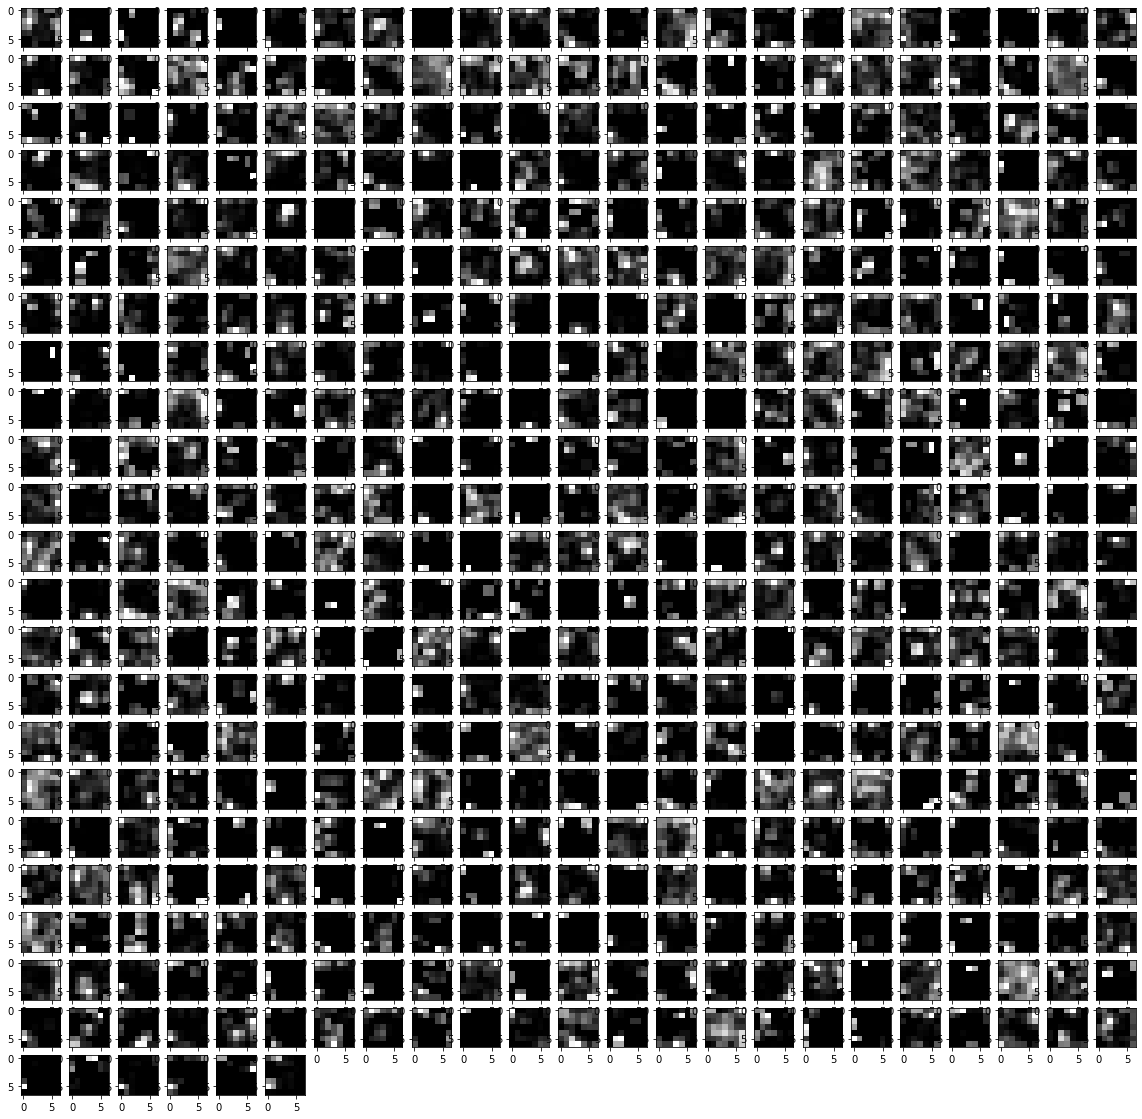

In [410]:
img_index = 0
plt.figure(figsize=(20, 20))
for i, filter in enumerate(outputs[img_index]):
    plt.subplot(23, 23, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter.detach().numpy(), cmap='gray')

In [163]:
outputs[img_index].detach().numpy().flatten().reshape(1, 25088).shape

(1, 25088)

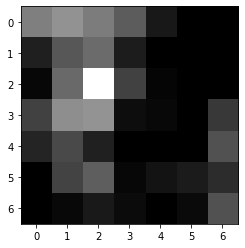

In [390]:
plt.imshow(outputs[0][505].detach().numpy(), cmap="gray")

In [411]:
output_means = [out.mean() for out in outputs[img_index].detach().numpy()]

In [412]:
max_activation = output_means.index(max(output_means))

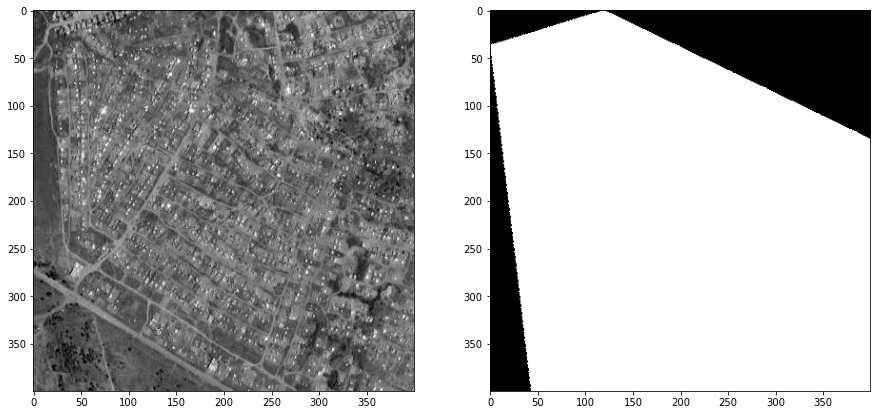

In [60]:
plt.figure(figsize=(15, 15))
img = cv2.imread("../images/ward_1/edited/0_0.png", cv2.IMREAD_GRAYSCALE)
plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
mask = cv2.imread("../images/ward_1/masks/0_0.png", cv2.IMREAD_GRAYSCALE)
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")

(12, 12)
(12, 12)
(12, 12)


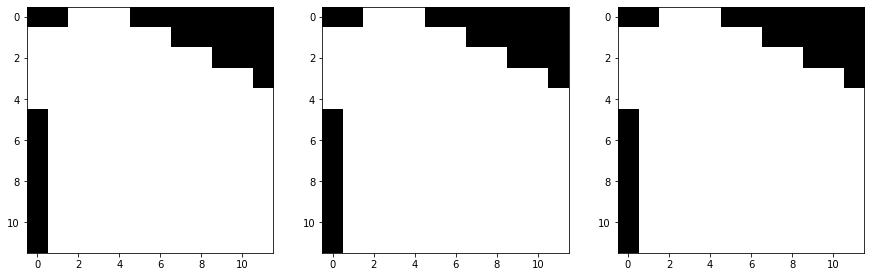

In [62]:
plt.figure(figsize=(15, 15))

mask = cv2.resize(mask, (12, 12), interpolation = cv2.INTER_AREA)
thresh = 130      # more evidence it's in ROI than out
mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1]
print(mask.shape)
plt.subplot(1, 3, 1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
plt.imshow(mask, cmap='gray')

mask = cv2.resize(mask, (12, 12), interpolation = cv2.INTER_NEAREST)
print(mask.shape)
plt.subplot(1, 3, 2) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
plt.imshow(mask, cmap='gray')

mask = cv2.resize(mask, (12, 12), interpolation = cv2.INTER_LINEAR)
print(mask.shape)
plt.subplot(1, 3, 3) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
plt.imshow(mask, cmap='gray')

In [417]:
def isolate(img, inds):
    img[inds] = 0
    return img

In [478]:
def apply_mask(filter_maps, img_num, img_list):
    mask = cv2.imread(os.path.join(CNN_IMAGE_DIR, 'ward_1', 'masks', img_list[img_num]), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (7, 7), interpolation = cv2.INTER_AREA)
    thresh = 130      # more evidence it's in ROI than out
    mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1]
    inds = np.where(mask == 0)
    return(torch.stack([isolate(img, inds) for img in filter_maps]))

In [479]:
def isolate_roi(outputs, ind):
    if (ind + 8) >= len(image_order):
        img_list = image_order[ind:]
    else:
        img_list = image_order[ind:ind+8]
    print(img_list)
    outputs_copy = outputs.detach().clone()
    return(torch.stack([apply_mask(img_filters, i, img_list) for i, img_filters in enumerate(outputs_copy)]))

In [480]:
def flatten_maps(filter_maps):
    flattened_maps = np.stack([img_filter_map.flatten().reshape(1, 25088) for img_filter_map in filter_maps], axis=0)
    flattened_maps_torch = torch.tensor(flattened_maps)
    return(flattened_maps_torch)

In [46]:
ind = 0
isolated_filter_maps = isolate_roi(outputs, ind)
flattened_filter_maps = flatten_maps(isolated_filter_maps)
out = mod_reduce_dim(flattened_filter_maps)

['0_0.png', '0_1.png', '0_2.png', '0_3.png', '0_4.png', '1_0.png', '1_1.png', '1_2.png']


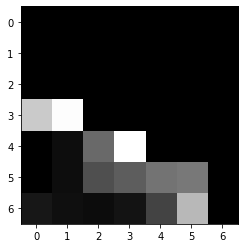

In [49]:
plt.imshow(isolated_filter_maps[1][17], cmap="gray")

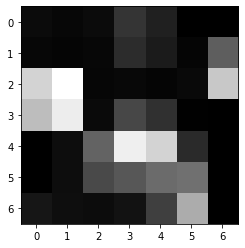

In [50]:
plt.imshow(outputs[1][17].detach().numpy(), cmap="gray")

44
(7, 7)


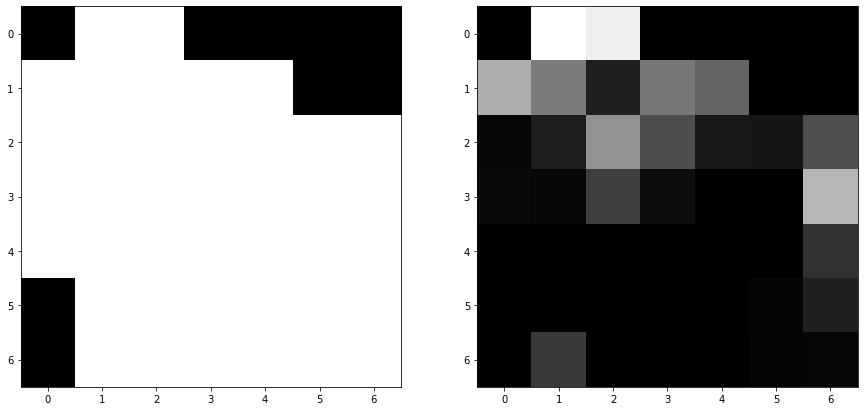

In [238]:
print(max_activation)
img = cv2.imread("../images/ward_1/edited/00_mask.png", cv2.IMREAD_GRAYSCALE)
# img[np.where(img != 0)] = 255
res = cv2.resize(img, (7, 7), interpolation = cv2.INTER_AREA)
thresh = 130      # more evidence it's in ROI than out (do we want to lose ROI or gain pixels not in ROI??)
res = cv2.threshold(res, thresh, 255, cv2.THRESH_BINARY)[1]
out = outputs[img_index][10].detach().numpy()
out[np.where(res == 0)] = 0
print(res.shape)
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
plt.imshow(res, cmap='gray')
# plot_fig(res)
plt.subplot(1, 2, 2) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
plt.imshow(out, cmap="gray")

70


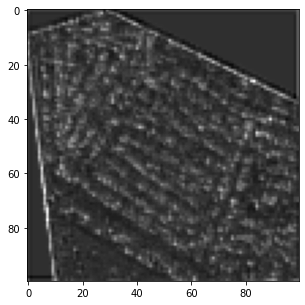

In [159]:
# print(max_activation)
# plot_fig(outputs[img_index][max_activation].detach().numpy())

In [32]:
outputs[img_index][max_activation].detach().numpy().shape

(50, 50)

In [185]:
outputs[img_index][max_activation].detach().numpy().max()

6.2437696

(100, 100)


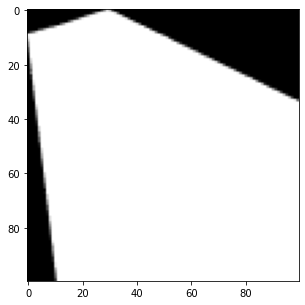

In [186]:
mask = cv2.imread('../images/ward_' + str(1)+ '/test/' + "00_mask_small.png", cv2.IMREAD_GRAYSCALE)
print(mask.shape)
plot_fig(mask)

In [187]:
inds = np.where(mask == 0)      # black pixels
outputs[img_index][max_activation].detach().numpy()[inds] = 0
outputs[img_index][max_activation].detach().numpy().shape

(100, 100)

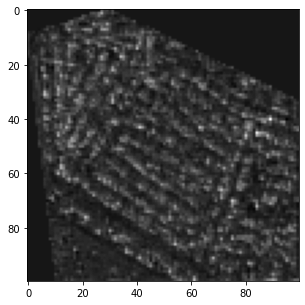

In [188]:
plot_fig(outputs[img_index][max_activation].detach().numpy())

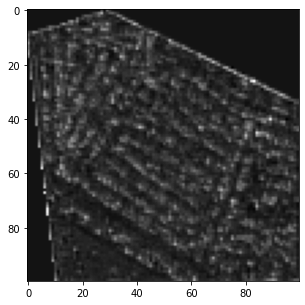

In [164]:
# plot_fig(outputs[img_index][max_activation].detach().numpy())

In [ ]:
transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

# custom dataset for fast image loading and processing
# does not follow the usual style of folder -> folder for each class -> image
# we just want one folder with images
class ForwardPassDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transformer):
        self.image_dir = image_dir
        self.image_list = os.listdir(self.image_dir)
        self.transformer = transformer

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image_name = self.image_list[index]

        # Load image
        X = self.filename_to_im_tensor(self.image_dir + '/' + image_name)
        
        # dataloaders need to return a label, but for the forward pass we don't really care
        return X, -1
    
    def filename_to_im_tensor(self, file):
        im = plt.imread(file)[:,:,:3]
        im = self.transformer(im)
        return im

model = model.eval()  
classes = [0, 1, 2]
# shape of final array will be (num_validation_images, 4096)
# we also want to record the image each index represents
image_order = []
i = 0
# for c in classes:
    # use the validation images to do the forward pass
dataset = ForwardPassDataset(os.path.join(CNN_IMAGE_DIR, 'ward_1', 'edited'), transformer)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=4)   # loading data into an iterator
image_order += dataset.image_list
feats = np.zeros((len(dataset.image_list), 4096))
# forward pass for this class
for inputs, _ in tqdm(dataloader):
    inputs = inputs.to(device)
    outputs = model(inputs)
    print(outputs.shape)
    feats[i:i+len(inputs),:] = outputs.cpu().detach().numpy()
    i += len(inputs)

In [ ]:
image_order

In [37]:
type(feats)

numpy.ndarray

In [35]:
feats.shape

(26, 4096)

In [10]:
# df = pd.read_csv("ward_1_features2.csv", header=None)
# df.shape

(26, 4096)

In [11]:
# df.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,-0.778296,1.101634,-0.195905,-0.473116,-0.231894,-0.934120,-0.378721,-0.282832,-0.247623,-0.039586,...,-1.705159,-0.354096,0.884349,0.225667,-0.615039,-0.134482,-0.323505,0.042665,0.095192,-1.197510
1,-0.202708,1.235139,-0.827911,0.155087,0.069151,0.192156,1.308368,-0.463421,-0.154223,0.364289,...,-0.650816,-0.096511,-0.360049,0.193063,-0.297557,-0.698389,-0.273726,-0.242009,-0.163236,-0.528908
2,-1.023651,0.382917,0.746485,-0.838750,-0.606340,-1.505373,-1.216838,-0.641110,0.339537,-0.182442,...,-1.893061,-1.111037,1.364203,0.314867,-0.840509,-0.890774,-0.839850,-0.063383,0.215264,-1.542947
3,-0.703414,0.116613,-0.162120,-0.530230,0.356845,-0.826925,0.154162,-0.397937,0.335160,-0.171340,...,-1.060569,0.466816,0.421030,-0.201160,-0.296505,-0.265536,-0.381527,0.104498,1.009635,-0.945967
4,-1.317655,-0.072199,-0.393116,-0.461869,0.980177,-1.272359,0.151135,-1.094211,1.169212,0.051910,...,-1.252388,0.189196,0.174689,-0.655693,1.046035,-0.675453,-0.891041,0.048363,0.190256,-1.215918


In [192]:
img = feats[2,:].reshape(64,64)
img

array([[-1.02365100e+00,  3.82916659e-01,  7.46484935e-01, ...,
        -1.62205482e+00, -1.18176007e+00, -1.83857784e-01],
       [-8.02869976e-01, -1.02299943e-07,  7.75736749e-01, ...,
        -1.00719953e+00, -4.14795101e-01, -2.15225264e-01],
       [-9.12544429e-01,  3.99053156e-01, -4.68584716e-01, ...,
        -4.76129532e-01, -5.12916803e-01, -3.65512341e-01],
       ...,
       [-8.54388475e-02, -7.53494442e-01, -1.11963069e+00, ...,
        -1.81058779e-01, -2.00211644e+00, -1.63083386e+00],
       [-5.77050447e-01, -8.64988029e-01, -8.59190583e-01, ...,
        -1.64632931e-01, -1.72122586e+00, -4.88053620e-01],
       [-1.09366345e+00, -4.24754381e-01, -1.45295942e+00, ...,
        -6.33833483e-02,  2.15263963e-01, -1.54294693e+00]])

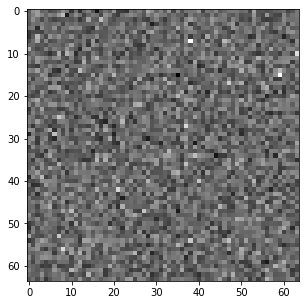

In [193]:
plot_fig(img)

In [194]:
width = 64
height = 64
dim = (width, height)
# resize image
mask = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)

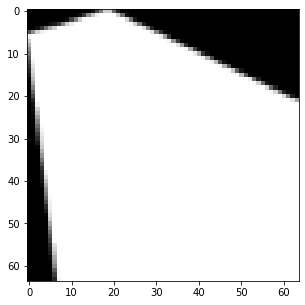

In [195]:
plot_fig(mask)

In [199]:
inds = np.where(mask == 0)      # black pixels
img[inds] = img.min()           # need to change this for the cnn
img.shape

(64, 64)

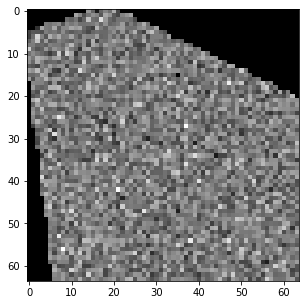

In [200]:
plot_fig(img)

In [36]:
forward_pass_df = pd.DataFrame.from_dict({'image_name': image_order, 'feat_index': np.arange(len(image_order))})
forward_pass_df.head()

,image_name,feat_index
0,10.513181862198008_39.768191057994024_10.52815...,0
1,-14.632534157196016_34.981995235794024_-14.662...,1
2,-14.526346764205977_35.593520078598004_-14.481...,2
3,7.4290196173360155_7.26950147266_7.45896346014...,3
4,-10.405547698244352_34.14279535535209_-10.4038...,4


In [37]:
df_consumption = pd.merge(left=df_images, right=forward_pass_df, on='image_name')

In [40]:
# have we maintained all validation images?
assert len(df_consumption) == (~df_images['is_train']).sum()

In [41]:
df_consumption.head()

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,cons_pc,nightlights,country,nightlights_bin,is_train,feat_index
0,-17.125093842803985_35.18726915719602_-17.0951...,-17.125094,35.187269,-17.095150,35.217213,1.423239,0.025206,mw,0,False,318
1,-17.140065764205975_35.232184921401995_-17.095...,-17.140066,35.232185,-17.095150,35.217213,1.423239,0.025206,mw,0,False,1861
2,-17.065206157196016_35.262128764205976_-17.095...,-17.065206,35.262129,-17.095150,35.217213,1.423239,0.025206,mw,0,False,836
3,-17.07737907859801_35.069727235794026_-17.0923...,-17.077379,35.069727,-17.092351,35.114643,1.266204,0.000000,mw,0,False,18
4,-17.137266764205975_35.08469915719602_-17.0923...,-17.137267,35.084699,-17.092351,35.114643,1.266204,0.000000,mw,0,False,1051


## Aggregate Features
For each country, we aggregate the image features per cluster and save them to results/country/cnn

In [47]:
country_abbrv = ['mw', 'eth', 'ng']
country_dir = ['malawi_2016', 'ethiopia_2015', 'nigeria_2015']

for ca, cd in zip(country_abbrv, country_dir):
    df_c = df_consumption[df_consumption['country'] == ca]
    group = df_c.groupby(['cluster_lat', 'cluster_lon'])
    x = np.zeros((len(group), 4096))
    cluster_list = [] # the corresponding clusters (lat, lon) to the x aggregate feature array
    for i, g in enumerate(group):
        lat, lon = g[0]
        im_sub = df_consumption[(df_consumption['cluster_lat'] == lat) & (df_consumption['cluster_lon'] == lon)].reset_index(drop=True)
        agg_feats = np.zeros((len(im_sub), 4096))
        for j, d in im_sub.iterrows():
            agg_feats[j,:] = feats[d.feat_index]
        agg_feats = agg_feats.mean(axis=0) # averages the features across all images in the cluster

        x[i,:] = agg_feats
        cluster_list.append([lat, lon])
    # save to the correct directory
    save_dir = os.path.join(RESULTS_DIR, cd, 'cnn')
    os.makedirs(save_dir, exist_ok=True)
    np.save(os.path.join(save_dir, 'cluster_feats.npy'), x)
    pickle.dump(cluster_list, open(os.path.join(save_dir, 'cluster_order.pkl'), 'wb')) 
    